> # Trading Strategies using Machine Learning
---

- Benchmark study that uses GARCH and Kalman Filter

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

/Users/rahulodedra/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


> ### Benchmark model
---

### GARCH

[*********************100%%**********************]  1 of 1 completed
/var/folders/vs/03bk43jj4jn9ptfvw49_hbv80000gn/T/ipykernel_16801/1323670742.py:45: OptimizeWarning: Unknown solver options: xtol
  results = minimize(garch, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


         Current function value: -12778.766367
         Iterations: 2
         Function evaluations: 122
         Gradient evaluations: 22
RMSE values is:  0.043509766411021035


/var/folders/vs/03bk43jj4jn9ptfvw49_hbv80000gn/T/ipykernel_16801/1323670742.py:49: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y_GARCH = np.hstack(path.values())


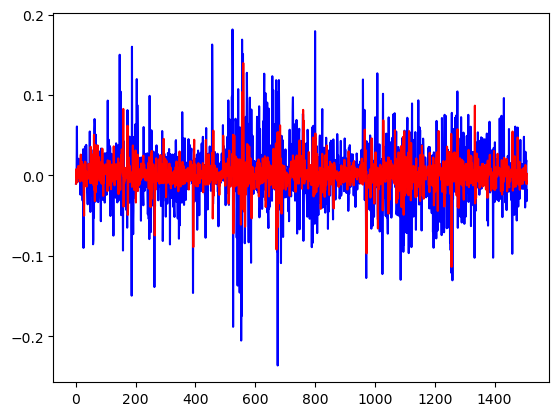

In [4]:
def garch(param, *args):
    # Initialize Params
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    GARCH_Dens, sigma2, F, v = {}, {}, {}, {} 
    # intialize values 
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])     
        Likelihood += GARCH_Dens[t]  
    
    return Likelihood

def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    sigma2, path = {}, {}
    # initialzie volatility and path
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1])
        path[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
        
    return path, sigma2    

start_date = datetime(2018,1,1)
end_date = datetime(2023,12,31)
stock_symbol = 'TSLA'
stock = yf.download(stock_symbol,start_date ,end_date)
# Y = stock['Adj Close'].values
Y = np.diff(np.log(stock['Adj Close'].values))
T = Y.shape[0]

param0 = np.array([np.mean(Y), np.var(Y)/600, 0.1, 0.4])

results = minimize(garch, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
param_star = results.x

path, vol = garch_path(param_star, Y, T)
Y_GARCH = np.hstack(path.values())
timevec = np.linspace(1,T,T)
plt.plot(timevec, Y,'b',timevec, Y_GARCH,'r')

RMSE = np.sqrt(np.mean((Y_GARCH - Y)**2))
print('RMSE values is: ', RMSE)

### Kalman Filter

[*********************100%%**********************]  1 of 1 completed
/var/folders/vs/03bk43jj4jn9ptfvw49_hbv80000gn/T/ipykernel_16801/3855098330.py:69: OptimizeWarning: Unknown solver options: xtol
  results = minimize(kalman_filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


         Current function value: -1761.246091
         Iterations: 1
         Function evaluations: 239
         Gradient evaluations: 46
RMSE values is: $ 0.24002993677305026


/var/folders/vs/03bk43jj4jn9ptfvw49_hbv80000gn/T/ipykernel_16801/3855098330.py:74: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y_kalmanFilter = np.hstack(path.values())


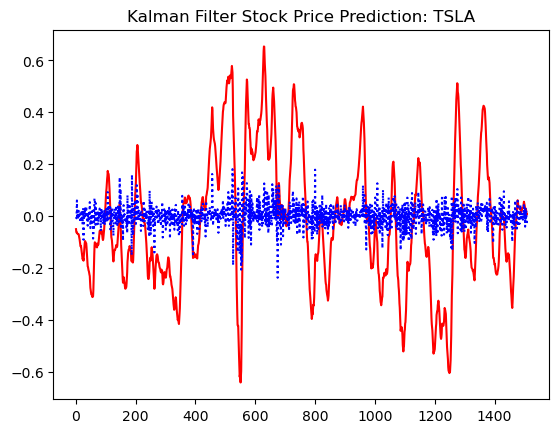

In [5]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

        
def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3] 
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    
    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path 


start_date = datetime(2018,1,1)
end_date = datetime(2023,12,31)
stock_symbol = 'TSLA'
stock = yf.download(stock_symbol,start_date ,end_date)
# Y = stock['Adj Close'].values
Y = np.diff(np.log(stock['Adj Close'].values))

S = Y.shape[0]

param0 = np.array([0.3,1.0, np.var(Y)/500, np.var(Y)/500]) 

results = minimize(kalman_filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})

# smoothe and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
Y_kalmanFilter = np.hstack(path.values())
Y_kalmanFilter = Y_kalmanFilter[::-1]

timevec = np.linspace(1,S,S)
plt.title('Kalman Filter Stock Price Prediction: '+ stock_symbol)
plt.plot(timevec, Y_kalmanFilter,'r',timevec, Y,'b:')

RMSE = np.sqrt(np.mean((Y_kalmanFilter - Y)**2))
print('RMSE values is: $', RMSE)